In [1]:
#pip install plotly

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import plotly.express as px
import seaborn as sns

In [7]:
# Load the .xls file using the xlrd engine
df = pd.read_excel("Deal_Bitrix.xlsx")
# Display the first few rows of the dataframe
df.head()

,ID,Pipeline,Repeat deal,Repeat inquiry,Stage,Observers,"Probability, %",Payment status,Delivery status,Responsible,...,Company: Instagram comments,Company: Network contact,Company: Live Chat,Company: Open Channel account,Company: ICQ Number,Company: MSN/Live!,Company: Jabber,Company: Other Contact,Company: Linked user,Company: Status
0,8751,General,N,Y,Reach,NaN,NaN,NaN,NaN,Preetika Karnik,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ongoing
1,8747,General,N,Y,Meeting Booked,NaN,10.0,NaN,NaN,Jaya Maurya,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ongoing
2,8745,General,N,Y,Reach,NaN,NaN,NaN,NaN,Siddharth Pandey,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ongoing
3,8743,General,N,Y,Reach,NaN,NaN,NaN,NaN,Preetika Karnik,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ongoing
4,8741,General,N,Y,Reach,NaN,NaN,NaN,NaN,Jaya Maurya,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ongoing


In [1]:
# for col in df.columns:
#     print(f"Column: {col}")
#     print(f"Data Type: {df[col].dtype}")
#     print(f"Number of Unique Values: {df[col].nunique()}")
#     print(f"Number of Missing Values: {df[col].isnull().sum()}")
#     print(f"Sample Values: {df[col].unique()[:5]}")
#     print("-" * 30)

In [8]:
# Selecting columns we need for analysis
sel_cols = f"ID, Created, Modified, Stage, Created by, Modified by, Responsible, Repeat inquiry, Deal Name, Type, Source, Company, Contact, UTM Source, UTM Medium, UTM Campaign, UTM Content, UTM Term, Lead Status, Reason for Loss, Reasons for Win, Follow Up Status, Nature of Project, Services, LS - Service Fit, LS - Urgency, LG - Budget Availability, LG - Decision Making Capability, Contact: ID, Contact: First name, Contact: Last name, Contact: Position, Contact: Responsible person, Contact: Source, Contact: Work Phone, Contact: Mobile, Contact: Shopify Store URL, Contact: Do you have a shopify website, Contact: Do you want to build a shopify website, Contact: Do you have a D2C/eCommerce webiste, Contact: Do you need any help with your online business?, Company: Company Name"
sel_cols_list = sel_cols.split(", ")
df = df[sel_cols_list]
# df.info()

In [9]:
# Modifying time columns to datetime variable
df['Created'] = pd.to_datetime(df['Created'], format='%d.%m.%Y %H:%M:%S')
df['Modified'] = pd.to_datetime(df['Modified'], format='%d.%m.%Y %H:%M:%S')

In [26]:
#Extracting all stages
shuffled_stages = df['Stage'].unique().tolist()
shuffled_stages

['Reach',
 'Meeting Booked',
 'Develop',
 'Attract',
 'Proposal',
 'Onboarded',
 'SQL',
 'Contract Sent',
 'Renewal',
 'Analyze failure',
 'Negotiation']

In [28]:
#stages
stages = ['Reach','Attract','Develop','Meeting Booked','SQL','Proposal','Contract Sent','Negotiation','Onboarded','Renewal', 'Analyze failure']

In [29]:

# Making cumulative of stages by repeating all stages after it to that stage in an expanded dataframe
def expand_cumulative_stages(df, stages, stage_col='Stage'):
    expanded_data = []
    
    # Iterate through each row in the DataFrame
    for _, row in df.iterrows():
        current_stage_index = stages.index(row[stage_col])
        
        # Repeat the row for the current stage and all preceding stages
        for stage in stages[:current_stage_index + 1]:
            new_row = row.copy()
            new_row[stage_col] = stage
            expanded_data.append(new_row)
    
    # Create a new DataFrame with the expanded data
    expanded_df = pd.DataFrame(expanded_data)
    return expanded_df

# Apply the transformation to create cumulative stages
cum_stages_breakdown_expanded = expand_cumulative_stages(df, stages)

    

In [30]:
cum_stages_breakdown_expanded['Count']=1

In [31]:
cum_stages_breakdown_expanded['Responsible'].unique()

array(['Preetika Karnik', 'Jaya Maurya', 'Siddharth Pandey',
       'Aditya Singh', 'Shashank Sharma'], dtype=object)

In [32]:

# Sidebar for user inputs
# st.sidebar.title("Filter Options")

# Add date range filter in the sidebar
min_date = cum_stages_breakdown_expanded['Created'].min()
max_date = cum_stages_breakdown_expanded['Created'].max()
# start_date, end_date = st.sidebar.date_input(
#     "Select Date Range",
#     [min_date, max_date],
#     min_value=min_date,
#     max_value=max_date
# )
start_date, end_date = min_date, max_date

# List of potential filter columns
filter_columns = ['Lead Status', 'Responsible']

# Dictionary to store selected filters
selected_filters = {'Lead Status':['Junk', 'Connection Made', 'Connection yet to be made',
       'Dead', 'Request Sent', 'New Lead', 'No Show', 'Won', 'Nurture',
       'Request Accepted'], 'Responsible':['Preetika Karnik', 'Jaya Maurya', 'Siddharth Pandey',
       'Aditya Singh', 'Shashank Sharma']}

# Loop through each filter column and create a multiselect dropdown
# for col in filter_columns:
#     unique_values = list(cum_stages_breakdown_expanded[col].dropna().unique())
#     selected_values = st.sidebar.multiselect(f'Select {col}', unique_values, default=unique_values)
#     selected_filters[col] = selected_values

# Dropdown for selecting the breakdown variable
# breakdown_var = st.sidebar.selectbox(
#     'Select Breakdown Variable',
#     'Lead Status'
# )
breakdown_var = 'Lead Status'

# Filter the DataFrame based on user-selected filters and date range
filtered_df = cum_stages_breakdown_expanded.copy()

# Apply the date range filter
filtered_df = filtered_df[(filtered_df['Created'] >= pd.to_datetime(start_date)) & 
                          (filtered_df['Created'] <= pd.to_datetime(end_date))]

# Apply additional filters for categorical columns
for col, values in selected_filters.items():
    filtered_df = filtered_df[filtered_df[col].isin(values)]

# Group the data by Stage and the selected breakdown variable
cumulative_grouped = filtered_df.groupby(['Stage', breakdown_var])['Count'].sum().reset_index()

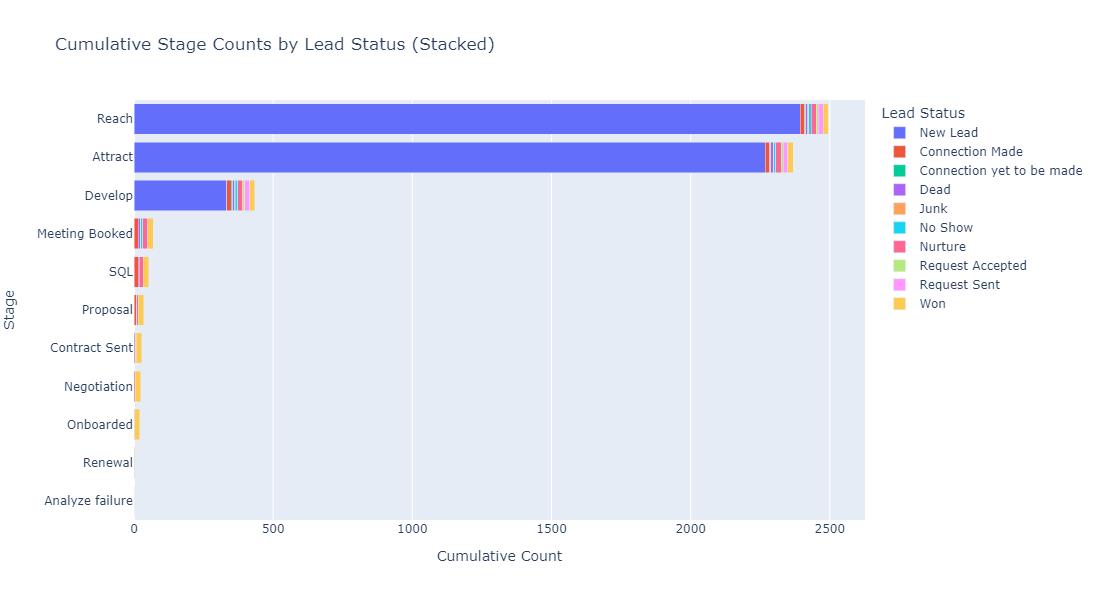

In [33]:

# Create a stacked horizontal bar graph using Plotly
fig = px.bar(
    cumulative_grouped,
    x='Count',
    y='Stage',
    color=breakdown_var,  # Color bars based on the breakdown column
    orientation='h',         # Horizontal orientation
    barmode='stack',         # Stack bars within each stage
    labels={'Cumulative Count': 'Cumulative Count', 'Stage': 'Stage'},
    title=f'Cumulative Stage Counts by {breakdown_var} (Stacked)'
)

# Update layout for better visualization
fig.update_layout(
    yaxis={'categoryorder': 'total ascending'},  # Reverse the stage order
    xaxis_title='Cumulative Count',
    yaxis_title='Stage',
    legend_title=breakdown_var,
    width=800,
    height=600
)

# Show the plot
fig.show()
